In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import time
import sqlite3
from tabulate import tabulate

# 定数
RANKING_PAGE_URL = "https://onsen.nifty.com/rank/year/"
OUTPUT_FILE = "onsen_comments.csv"
DB_FILE = "onsen.db"
HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
        "(KHTML, like Gecko) Chrome/87.0.4280.66 Safari/537.36"
    )
}
def fetch_page(url):
    """指定したURLからHTMLデータを取得し、BeautifulSoupオブジェクトを返す"""
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return BeautifulSoup(response.text, "html.parser")
    except requests.exceptions.RequestException as e:
        print(f"[ERROR] Failed to fetch: {url}\n{e}")
        return None

def extract_facility_urls(ranking_url, limit=10):
    """ランキングページから指定件数の温泉施設URLを取得"""
    soup = fetch_page(ranking_url)
    if not soup:
        return []
    facility_li_list = soup.select("li.normal, li.small, li.mini")
    facility_urls = [
        li.select_one("a[href]").get("href", "")
        for li in facility_li_list if li.select_one("a[href]")
    ]
    # 絶対URL形式に変換し重複を削除
    facility_urls = [
        href if href.startswith("http") else f"https://onsen.nifty.com{href}"
        for href in facility_urls
    ]
    return list(dict.fromkeys(facility_urls))[:limit]

def scrape_facility_details(facility_url):
    """温泉施設の詳細と口コミを取得"""
    soup = fetch_page(facility_url)
    if not soup:
        return {
            "name": "N/A", "address": "N/A", "tel": "N/A",
            "comment1": "N/A", "comment2": "N/A"
        }

    # テキスト抽出用の関数
    def extract_text(selector):
        element = soup.select_one(selector)
        return element.text.strip() if element else "N/A"

    # 温泉施設情報
    name = extract_text("th:contains('施設名') + td")
    address = extract_text("th:contains('住所') + td")
    tel = extract_text("th:contains('TEL') + td")

    # 口コミを最大2件取得
    comments_section = soup.select("div#kuchikomi div.subSection")
    comments = [
        section.select_one("div.colSet p").get_text(strip=True)
        for section in comments_section[:2] if section.select_one("div.colSet p")
    ]
    comment1 = comments[0] if len(comments) > 0 else "N/A"
    comment2 = comments[1] if len(comments) > 1 else "N/A"

    return {"name": name, "address": address, "tel": tel, "comment1": comment1, "comment2": comment2}

def save_results(data, output_csv=True, output_db=True):
    """結果をCSVとSQLiteデータベースに保存"""
    if output_csv:
        with open(OUTPUT_FILE, "w", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=["name", "address", "tel", "comment1", "comment2"])
            writer.writeheader()
            writer.writerows(data)
        print(f"[INFO] CSV saved to '{OUTPUT_FILE}'")

    if output_db:
        conn = sqlite3.connect(DB_FILE)
        cursor = conn.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS onsen_facilities (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                name TEXT, address TEXT, tel TEXT,
                comment1 TEXT, comment2 TEXT
            )
        """)
        cursor.executemany("""
            INSERT INTO onsen_facilities (name, address, tel, comment1, comment2)
            VALUES (:name, :address, :tel, :comment1, :comment2)
        """, data)
        conn.commit()
        conn.close()
        print(f"[INFO] Data saved to SQLite database '{DB_FILE}'")

def main():
    """ランキングトップ10温泉施設をスクレイピングし結果を保存"""
    print("[INFO] Fetching top 10 facilities from ranking...")
    onsen_urls = extract_facility_urls(RANKING_PAGE_URL, limit=10)
    all_facilities = []

    for url in onsen_urls:
        details = scrape_facility_details(url)
        all_facilities.append(details)
        time.sleep(1)  # サーバー負荷を軽減するためのウェイト

    # 結果の表示
    print("\n--- スクレイピング結果 ---")
    print(tabulate(all_facilities, headers="keys", tablefmt="grid"))

    # 結果を保存
    save_results(all_facilities)

if __name__ == "__main__":
    main()




[INFO] Fetching top 10 facilities from ranking...

--- スクレイピング結果 ---
+--------------------------------------------------------------------------+---------------------------------------------------------+--------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
/System/Library/Fonts/Supplemental/NotoSansDuployan-Regular.ttf
/System/Library/Fonts/Supplemental/NotoSansSyriac-Regular.ttf
/System/Library/Fonts/NotoSansArmenian.ttc
/System/Library/Fonts/Supplemental/Arial Bold Italic.ttf
/System/Library/Fonts/Supplemental/NotoSansTaiLe-Regular.ttf
/System/Library/Fonts/Supplemental/NotoSansMongolian-Regular.ttf
/System/Library/Fonts/AppleSDGothicNeo.ttc
/System/Library/Fonts/Supplemental/NotoSansHatran-Regular.ttf
/System/Library/Fonts/Supplemental/NotoSansCanadianAboriginal-Regular.otf
/System/Library/Fonts/Supplemental/NotoSansPhoenician-Regular.ttf
/System/Library/Fonts/Supplemental/NotoSansOldNorthArabian-Regular.ttf
/System/Library/Fonts/Supplemental/NotoSansTakri-Regular.ttf
/System/Library/Fonts/Supplemental/NotoSansMro-Regular.ttf
/System/Library/Fonts/Supplemental/

/var/folders/yj/wx9t58d55sbcfzm0xlmrw1mm0000gn/T/ipykernel_87610/3780833587.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_df, x="頻度", y="カテゴリー", palette="viridis")


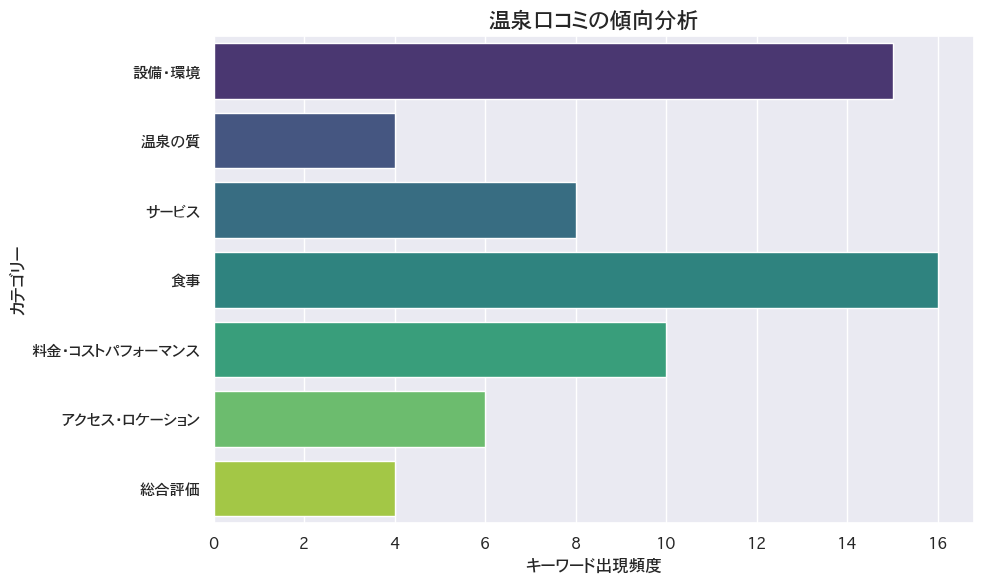

In [ ]:
%pip install janome

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from janome.tokenizer import Tokenizer
from collections import Counter
import matplotlib.font_manager as fm
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Noto" in font or "Gothic" in font or "ヒラギノ" in font or "Osaka" in font or "Arial" in font:
        print(font)

# フォント設定（日本語対応）
plt.rcParams['font.family'] = 'Osaka'

# CSVファイルの読み込み
csv_file = "onsen_comments.csv"  # CSVファイル名
df = pd.read_csv(csv_file)

# カテゴリーのキーワードを設定
categories = {
    "設備・環境": ["清潔", "景色", "施設", "露天風呂", "駐車場"],
    "温泉の質": ["泉質", "湯温", "温度", "肌", "お湯"],
    "サービス": ["スタッフ", "対応", "親切", "接客"],
    "食事": ["料理", "食事", "朝食", "夕食", "美味しい"],
    "料金・コストパフォーマンス": ["料金", "高い", "コスパ", "値段"],
    "アクセス・ロケーション": ["アクセス", "場所", "遠い", "近い", "景観"],
    "総合評価": ["満足", "また来たい", "リピート", "楽しめた"]
}

# コメント列を結合
comments = df["comment1"].fillna("") + " " + df["comment2"].fillna("")
all_comments = " ".join(comments)

# 日本語テキストをトークン化
tokenizer = Tokenizer()
tokens = [token.surface for token in tokenizer.tokenize(all_comments)]
# タイトルをトークン化
tokens += [token.surface for token in tokenizer.tokenize(" ".join(df["name"]))] 
# x軸, y軸のラベルをトークン化
tokens += [token.surface for token in tokenizer.tokenize(" ".join(df["address"]))]
tokens += [token.surface for token in tokenizer.tokenize(" ".join(df["tel"]))]
# キーワードをトークン化
for category, keywords in categories.items():
    tokens += [token.surface for token in tokenizer.tokenize(" ".join(keywords))]
    

# カテゴリーごとのキーワード出現頻度をカウント
category_counts = {category: 0 for category in categories}
for category, keywords in categories.items():
    category_counts[category] = sum(tokens.count(keyword) for keyword in keywords)

# 結果をDataFrameに変換
category_df = pd.DataFrame(list(category_counts.items()), columns=["カテゴリー", "頻度"])

# 口コミ分析のグラフを作成
plt.figure(figsize=(10, 6))
sns.barplot(data=category_df, x="頻度", y="カテゴリー", palette="viridis")
plt.title("温泉口コミの傾向分析", fontsize=16)
plt.xlabel("キーワード出現頻度", fontsize=12)
plt.ylabel("カテゴリー", fontsize=12)
plt.tight_layout()

# グラフを保存
plt.savefig("onsen_comment_analysis.png")
plt.show()
